# Quanvolution neural network
This example is based on the [paper](https://arxiv.org/abs/1904.04767): 

```Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.``` 

This example aimed at showing the performance and the usage of the new quantum processing framework -- JDQAI. 

## Quanvolution layer
The quantum convolution layer, a.k.a quanvolution layer, is a model providing a non-linear convolutional transformation of images, which can provide similar performance to classical non-linear transformation. The main goal is to find the quantum advantage in the non-linear transformation process. 

<img src="images/quanv.png" width=1000 />
(from ArXiv:1904.04767)

## About this example
In this example, the main struture of the example follow the one provided by [Pennylane](https://pennylane.ai/qml/demos/tutorial_quanvolution.html). The quanvolution transformation is done by a randomly generated quantum circuit. The images are pre-processed by the quanvolution layer and feed into a classical neural network. The performance of the quanvolution is comparing to a conventional convolution method in the end of the example. 

### MNIST Dataset
MNIST is a database of handwritten digits. 


# Initialization

In [1]:
import tedq as qai

# Related package
import torch
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt


2022-08-01 23:42:52.837573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cyc/software/root/lib


# Parameters

In [2]:
n_layers = 3    # Number of random layers
n_qubits = 4     # Number of qubits
n_epochs = 50   # Number of optimization epochs
n_train = 80    # Size of the train dataset
n_test = 40     # Size of the test dataset

np.random.seed(21)           # Seed for NumPy random number generator
SAVE_PATH = "./_data/quanvolution/" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH

# Load mnist dataset

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])



# Build a circuit for quanvolution process

### Define the circuit with JDQAI framework

In [4]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
def circuitDef(phi):
    for j in range(4):
        qai.RY(np.pi * phi[j], qubits=[j])
    # Generate random circuit    
    qai.templates.RandomLayer(n_qubits, n_layers, 0.3, rand_params)
    
    exp_vals = [qai.measurement.expval(qai.PauliZ(qubits=[position])) for position in range(n_qubits)]
    return exp_vals

In [5]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.zeros(n_qubits))

### Draw quantum circuit with circuit visualizer in JDQAI

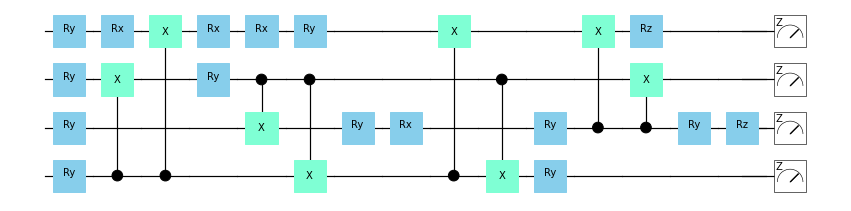

In [6]:
drawer = qai.matplotlib_drawer(circuit)
drawer.draw_circuit()

### Compile the circuit with pytorch backend

In [7]:
quanvCircuit = circuit.compilecircuit('pytorch')

log10(flops) of this quantum circuit:   3.2211533219547315


# Pre-process the images with quanvolution

In [8]:
def quanvolution(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = quanvCircuit(
                torch.tensor(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
                )
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [9]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanvolution(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanvolution(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

# Example output from quanvolution layer

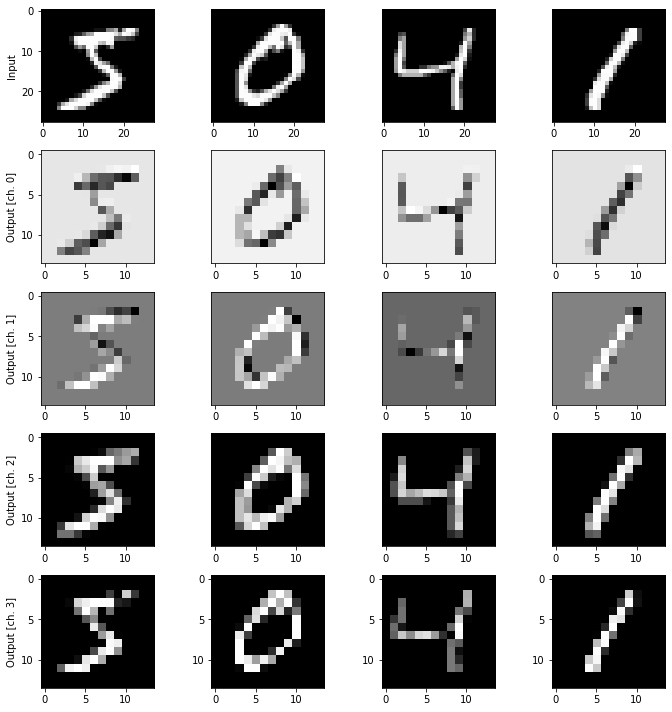

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Build quantum and classical model

## Quantum model
The model structure is 
```
Quan > Flatten > Dense(10)
```

## Classical model
The model structure is 
```
Conv > Flatten > Dense(10)
```

In [11]:
def qModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

def cModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(4, 2, 1, input_shape = (28, 28, 1), activation = 'relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Training classical and quantum model

In [12]:

c_history = cModel().fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


q_history = qModel().fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


2022-08-01 23:42:59.871624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cyc/software/root/lib
2022-08-01 23:42:59.871671: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
20/20 - 1s - loss: 2.1440 - accuracy: 0.3250 - val_loss: 1.8919 - val_accuracy: 0.4750 - 801ms/epoch - 40ms/step
Epoch 2/50
20/20 - 0s - loss: 1.4827 - accuracy: 0.7375 - val_loss: 1.4851 - val_accuracy: 0.6500 - 144ms/epoch - 7ms/step
Epoch 3/50
20/20 - 0s - loss: 0.9900 - accuracy: 0.8875 - val_loss: 1.1942 - val_accuracy: 0.7250 - 123ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.6177 - accuracy: 0.9375 - val_loss: 0.9773 - val_accuracy: 0.7750 - 115ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.3907 - accuracy: 0.9625 - val_loss: 0.8716 - val_accuracy: 0.8000 - 111ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.2521 - accuracy: 1.0000 - val_loss: 0.8310 - val_accuracy: 0.7750 - 108ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.1712 - accuracy: 1.0000 - val_loss: 0.8236 - val_accuracy: 0.7750 - 104ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.1256 - accuracy: 1.0000 - val_loss: 0.7884 - val_accuracy: 0.8000 - 110ms/epoch - 5ms/step
Epoch 9/50
20/2

# Result

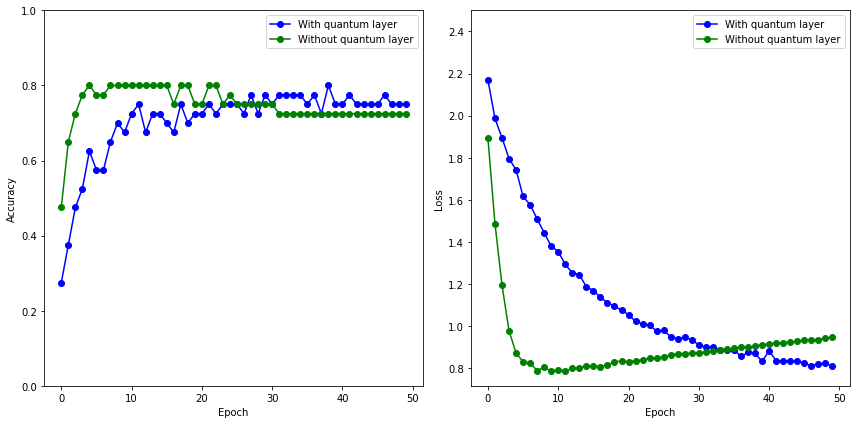

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
#fig.savefig("result.png")
plt.show()